In [30]:
import time
import tqdm

import pandas as pd

import pennylane as qml

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

plt.style.use("dark_background")

### Functions

In [2]:
def fit(model, loss_function, optimizer, fields, targets):

    model.train()

    predictions = model(fields)

    loss = loss_function(predictions, targets.float())

    model.zero_grad()

    loss.backward()

    optimizer.step()

    return loss.item()


def predict(model, fields):

    model.eval()

    with torch.no_grad():

        if not isinstance(fields, torch.Tensor):

            fields = torch.tensor(fields)

        predictions = model(fields).numpy()

    return predictions


def batch_predict(model, data_loader):

    targets = []
    predictions = []

    for fields, target in data_loader:

        prediction = predict(model, fields)

        targets.extend(target.tolist())
        predictions.extend(prediction.tolist())

    score = r2_score(targets, predictions)

    return predictions, score


def train(x_train, y_train, 
          x_test, y_test, 
          model,
          epochs=50,
          batch_size=8,
          learning_rate=0.001, 
          weight_decay=1e-6,
          printout_period=1):
    
    start_time = time.time()
    
    records_count = len(x_train)

    batches = records_count // batch_size
    
    loss_function = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    
    data_loader_train = torch.utils.data.DataLoader(
        list(zip(x_train, y_train)), 
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    
    data_loader_test = torch.utils.data.DataLoader(
        list(zip(x_test, y_test)), 
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    
    best_model = model
    best_avg_train_loss = 0
    best_avg_test_loss = 0
    
    train_losses = []
    test_losses = []
        
    total_records_count = epochs * records_count
    
    fit_batch_tracker = tqdm.trange(
        total_records_count,
        unit=' records',
        unit_scale=True,
        ncols=90,
        mininterval=1
    )
    
    for epoch in range(epochs):
        
        fit_batch_tracker.set_description(f"Epoch: {epoch + 1}")
               
        epoch_train_loss = 0
        
        for xs, ys in data_loader_train:
                   
            loss_evaluated = fit(model, loss_function, optimizer, xs, ys)
            
            epoch_train_loss += loss_evaluated
            
            fit_batch_tracker.update(batch_size)

            predictions = predict(model, xs)
            
        
        predictions, r2_train = batch_predict(model, data_loader_test)
        
        print("r2_train:", r2_train)

        # fit_batch_tracker.set_postfix(r2=f"{r2_train:.02f}")
            
        avg_train_loss = epoch_train_loss / batches
        train_losses.append(avg_train_loss)
        
        # Test
        
        model.eval()
        
        epoch_test_loss = 0
        
        for xs, ys in data_loader_test:
            
            loss_evaluated = loss_function(model(xs), ys)
            epoch_test_loss += loss_evaluated
            
        avg_test_loss = epoch_test_loss / batches
        
        test_losses.append(avg_test_loss)
        
        predictions, r2_test = batch_predict(model, data_loader_test)
        
        print("r2_test:", r2_test)
        
        
        if epoch == 0:
            best_avg_test_loss = avg_test_loss
            
        if avg_test_loss < best_avg_test_loss:
            best_avg_test_loss = avg_test_loss
            best_model = model
            
        # if not epoch % printout_period:
        #     print("Average train loss over epoch {}: {:.4f}".format(epoch, avg_train_loss))
        #     print("Average test loss over epoch {}: {:.4f}\n".format(epoch, avg_test_loss))
    
    print(f"Best train loss: {min(train_losses):.02f}")
    print(f"Best test loss: {best_avg_test_loss:.02f}")
    print(f"Train time: {time.time() - start_time:.02f} seconds")
    
    return best_model, (torch.tensor(train_losses), torch.tensor(test_losses))

### Data

In [31]:
data = pd.read_csv('water_potability.csv')

data.dropna(inplace=True)

data.shape

(2011, 10)

In [32]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [33]:
# Feature Scaling

standard_scaler = StandardScaler()

FEATURE_COLUMNS = data.columns[:-1]

scaled_features = standard_scaler.fit_transform(data[FEATURE_COLUMNS])

data[FEATURE_COLUMNS] = scaled_features

data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,0.782466,0.564114,0.011687,0.583804,0.574378,-0.783962,1.227032,2.111652,0.844761,0
4,1.275463,-0.455653,-0.455835,-0.370947,-0.560480,-0.348429,-0.842154,-2.140399,0.135033,0
5,-0.954835,-0.234614,0.790645,0.259104,-0.158911,-1.810063,-1.792340,-0.714423,-1.807366,0
6,1.994902,1.596951,0.790764,0.239248,1.467140,-1.770608,-0.170876,1.132494,-1.662163,0
7,0.985323,0.226606,-0.954313,-1.622878,-0.726179,0.595858,-0.599824,-0.224135,0.553348,0


In [4]:
DATA_LIMIT = 2011

limited_data = data[:DATA_LIMIT].copy()

train_length = int(len(limited_data) * 0.7)

data_train = limited_data[:train_length].copy()
data_test = limited_data[train_length:].copy()

print(len(limited_data), len(data_train), len(data_test))

2011 1407 604


### Model

In [5]:
n_qubits = 4
q_delta = 0.01
q_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(q_input_features):
        qml.RY(element, wires=idx)
    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for idx, element in enumerate(q_weights):
            qml.RY(element, wires=idx)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals

In [6]:
class DressedQuantumNet(nn.Module):
    
    def __init__(self, n_features):
        super(DressedQuantumNet, self).__init__()
        self.pre_net = nn.Linear(n_features, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, n_features)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = pre_out
        q_out = torch.Tensor(0, n_qubits)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

In [7]:
class Model(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        # self.fc2 = nn.Linear(hidden, hidden)
        # self.fc3 = nn.Linear(hidden, hidden)
        # self.fc4 = nn.Linear(hidden, hidden)
        self.dressed = DressedQuantumNet(hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = F.relu(self.dressed(x))
        x = self.fc6(x)
        
        # x = F.sigmoid(x)
        
        # print(x)
        
        return x

In [8]:
class ClassicalModel(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(ClassicalModel, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        # x = F.softmax(x, dim=1)
        # x = F.sigmoid(x)
        
        # print(x)
        
        return x

### 4 input parameters

In [9]:
FEATURE_COLUMNS = data_train.columns[:-1]

# FEATURE_COLUMNS = ['Hardness', 'Solids', 'Chloramines', 'Conductivity'] 
                   # 'Organic_carbon', 'Turbidity']
LABEL_COLUMN = ['Potability']

x_train = torch.tensor(data_train[FEATURE_COLUMNS].values).float()
y_train = torch.tensor(data_train[LABEL_COLUMN].values).float()

x_test = torch.tensor(data_test[FEATURE_COLUMNS].values).float()
y_test = torch.tensor(data_test[LABEL_COLUMN].values).float()

In [10]:
num_inputs = x_train.shape[1]

# model = Model(num_inputs=num_inputs)

model = ClassicalModel(num_inputs=num_inputs)

In [11]:
trained_model, loss = train(x_train, y_train, 
                            x_test, y_test,
                            model=model,
                            batch_size=8,
                            epochs=1, learning_rate=0.0001)

Epoch: 1: 100%|██████████████████████████████▊| 1.40k/1.41k [00:00<00:00, 4.62k records/s]

r2_train: -0.15776428677827603
r2_test: -0.1596204560989023
Best train loss: 2.11
Best test loss: 0.12
Train time: 0.31 seconds


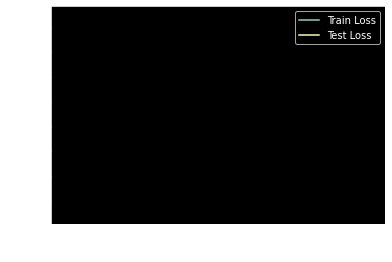

In [12]:
plt.plot(loss[0], label="Train Loss")
plt.plot(loss[1], label="Test Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend();

In [13]:
start_time = time.time()

y_pred = trained_model(x_train)

prediction = y_pred.detach().numpy()

print("Time: %s seconds" % (time.time() - start_time))

data_train.head()

prediction[0]

Time: 0.005552053451538086 seconds


array([0.49912837], dtype=float32)

In [14]:
# data_train.to_csv('hybrid_nn_dqc_train.csv', index=False)
# data_test.to_csv('hybrid_nn_dqc_test.csv', index=False)

In [15]:
loss_data = pd.DataFrame()
loss_data['train_loss'] = loss[0]
loss_data['test_loss'] = loss[1]
loss_data.to_csv('hybrid_nn_dqc_loss.csv', index=False)
loss_data.head()

,train_loss,test_loss
0,2.106091,0.123841


### Plots

In [19]:
def plot_stock_prices(data_train, data_test, title='train'):
    
    data_train = data_train.sort_values('initial_stock_price')
    data_test = data_test.sort_values('initial_stock_price')
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].scatter(data_train['initial_stock_price'], data_train['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[0].scatter(data_train['initial_stock_price'], data_train['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[0].set_title('Train')
    axs[1].scatter(data_test['initial_stock_price'], data_test['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[1].scatter(data_test['initial_stock_price'], data_test['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='initial stock price', ylabel='option price')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

    
def plot_loss(loss, title='train'):
    
    train_loss, test_loss = loss[0], loss[1]
    epochs = [i for i in range(len(train_loss))]
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].plot(epochs, train_loss, c='b')
    axs[0].set_title('Train')
    axs[1].plot(epochs, test_loss, c='b')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='epoch', ylabel='loss')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

In [22]:
# plot_loss(loss, 'hybrid_nn_dqc_loss')

In [23]:
# plot_stock_prices(data_train, data_test, title='hybrid_nn_dqc')